In [207]:
import typing as tp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import numpy as np
sns.set(font_scale=1.4, palette='Set2')

In [ ]:
# Bot check

# HW_ID: ds_ml8
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Исследование простой модели (60 баллов)

Это последний ноутбук в данном домашнем задании. Здесь вы исследуете влияние величины линейного слоя, инициализации и разных функций активации на обучение простой двухслойной модели. В качестве данных будет использоваться синтетическая выборка соответствующая примеру на лекции.

В данном ноутбуке **можно и нужно пользоваться PyTorch**. Все эксперименты будут вычислительно простыми, поэтому CUDA здесь не понадобится.

### 1. Реализация

Рассмотрим функцию с лекции:
$$f(x) = 0.2 + 1.4 x^2 + 0.3\sin(15x) + 0.1\cos(50x)$$
Будем приближать эту функции на отрезке $[0, 1]$ двухслойной нейронной сетью.
* Первый слой будет содержать обучаемые веса и смещения. А также некоторую функцию активации $\sigma(x)$.
* Второй слой будет содержать только обучаемые веса (без смещения), а функция активации будет тождественной.

Если в качестве $\sigma(x)$ взять функцию индикатора, то получится нейронная сеть точь в точь такая же как на лекции.

Начнем с простого. Реализуйте заданную функцию.

In [209]:
def function(x: torch.Tensor):  # ф-ция f(x)
    return 0.2 + 1.4*x**2 + 0.3*torch.sin(15*x) + 0.1*torch.cos(50*x)

In [210]:
assert torch.allclose(function(torch.tensor(0)), torch.tensor(0.3), 1e-4)
assert torch.allclose(function(torch.tensor(1)), torch.tensor(1.8916), 1e-4)
assert torch.allclose(function(torch.tensor(0.5)), torch.tensor(0.9305), 1e-4)

Реализуйте модель двухслойной нейронной сети как в описании.

In [211]:
class MyModel(torch.nn.Module):
    """Двухслойная нейросеть. n_hidden - кол-во нейронов на первом слое; activation - ф-ция активации на первом слое"""
    def __init__(self, n_hidden: int, activation: tp.Callable[[torch.Tensor], torch.Tensor]):
        super(MyModel, self).__init__()
        self.fc1, self.sigma, self.fc2 = nn.Linear(1, n_hidden), activation, nn.Linear(n_hidden, 1, bias=False)

    def forward(self, x):
        return self.fc2(self.sigma(self.fc1(x))) 

Сгенерируйте значения $x$ с помощью равномерной сетки с шагом 0.01 на отрезке $[0, 1]$. Также посчитайте соответствующие значения $f(x)$.

In [212]:
x = torch.arange(0, 1.01, 0.01).unsqueeze(1)  # понадобилось добавить unsqueeze(1)
y_true = function(x)
assert x.shape == y_true.shape == (101, 1), (x.shape, y_true.shape)

Напишите функцию для обучения сети. В данном случае, мы будем подавать в сеть всю выборку сразу, поэтому нет необходимости по ней итерироваться. По ходу обучения будет сохраняться поле `loss`. Это скаляр, поэтому при сохранении используем метод тензора `item`.

In [213]:
def train(model, optimizer, criterion, x, y, n_epochs):
    """Цикл обучения нейросети. model - модель; optimizer - оптимизатор; critetion - функция ошибки; x,y - входные данные; n_epochs - кол-во эпох"""
    history = {'loss': []}  # история обучения
    model.train()  # вводим в привычку
    for i in range(n_epochs):  # цикл обучения
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
    return history

Напишите функцию для получения предсказания. Воспользуйтесь конструкцией, которая позволяет не считать градиенты при прогоне модели.

In [214]:
def eval(model, x):
    """Предскзание модели. model - модель; x - входные данные."""
    model.eval()  # вводим в привычку
    with torch.no_grad():
        y_pred = model(x)
    return y_pred

В качестве лосса и метрики будем использовать MSE.

In [215]:
mse = torch.nn.MSELoss()

### 2. Эксперименты

Для начала в качестве функции активации $\sigma(x)$ возьмем индикатор $I\{x > 0\}$ как на лекции.

In [216]:
def indicator(x, threshold=0):
    return (x > threshold).to(torch.float32)

Инициализируйте модель. Сохраним значения весов модели. Сделайте одну итерацию обучения (одну эпоху). В качестве оптимизатора используем `SGD`. Сравните новые веса модели со старыми. Объясните результат.

In [217]:
model = MyModel(n_hidden=100, activation=indicator)

# веса до итерации обучения
w1_init = model.fc1.weight.detach().clone()
b1_init = model.fc1.bias.detach().clone()
w2_init = model.fc2.weight.detach().clone()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
history = train(model, optimizer, mse, x, y_true, n_epochs=1)

# веса после итерации обучения
w1_new = model.fc1.weight.detach().clone()
b1_new = model.fc1.bias.detach().clone()
w2_new = model.fc2.weight.detach().clone()

torch.allclose(w1_init, w1_new), torch.allclose(b1_init, b1_new), torch.allclose(w2_init, w2_new)

(True, True, False)

***Ответ:** изменились только параметры 2го слоя (w2), в то время как параметры 1го слоя (w1 и b1) не поменялись. Это объясняется тем, что градиенты занулились перед передачей в первый слой. А занулились они из-за формы функции активации (ступенька-индикатор, зануляющая значения ниже порога)*

Попробуем сгладить наш индикатор. Реализуйте другую функцию активации &mdash; *сигмоиду с температурой*.
Ее отличие от обычной состоит в множителе в показателе экспоненты:

$$f(x) = \frac{1}{1 + e^{-T \cdot x}}$$

In [218]:
def tempered_sigmoid(x, temperature=50):
    """Сигмоида с температурой. input - входной тензор; T - температура"""
    return 1 / (1 + torch.exp(-temperature * x))

Визуализируйте зависимость от температуры:

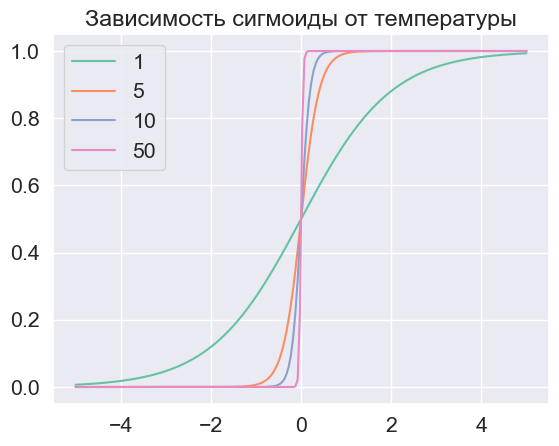

In [219]:
grid = torch.linspace(-5, 5, 200)
temperatures = [1, 5, 10, 50]
plt.title('Зависимость сигмоиды от температуры')
for temp in temperatures:
    plt.plot(grid, tempered_sigmoid(grid, temp), label=temp)
plt.legend()
plt.show()

Сравним эти функции активации с еще тремя, которые были у вас на лекции: `ReLU`, `LeakyReLU`, `GELU`. У каждой зададим `learning_rate`.

In [220]:
activation_functions = {
    'Индикатор': [indicator, 0.01],
    'Сигмоида (t)': [tempered_sigmoid, 0.01],
    'ReLU     ': [nn.ReLU(), 0.1],
    'LeakyReLU': [nn.LeakyReLU(), 0.1],
    'GELU     ': [nn.GELU(), 0.1]
}

Инициализируйте и обучите модель с каждой функцией активации 5 раз, и выберете лучшее предсказание по MSE. Построим график с лучшим предсказанием для каждой функции активации. Сравните эти предсказания между собой по MSE. Отличаются ли предсказания в случаях индикаторной функции и сигмоиды?

In [221]:
n_times = 5

Индикатор 	 0.0277
Сигмоида (t) 	 0.0103
ReLU      	 0.0342
LeakyReLU 	 0.0331
GELU      	 0.0449


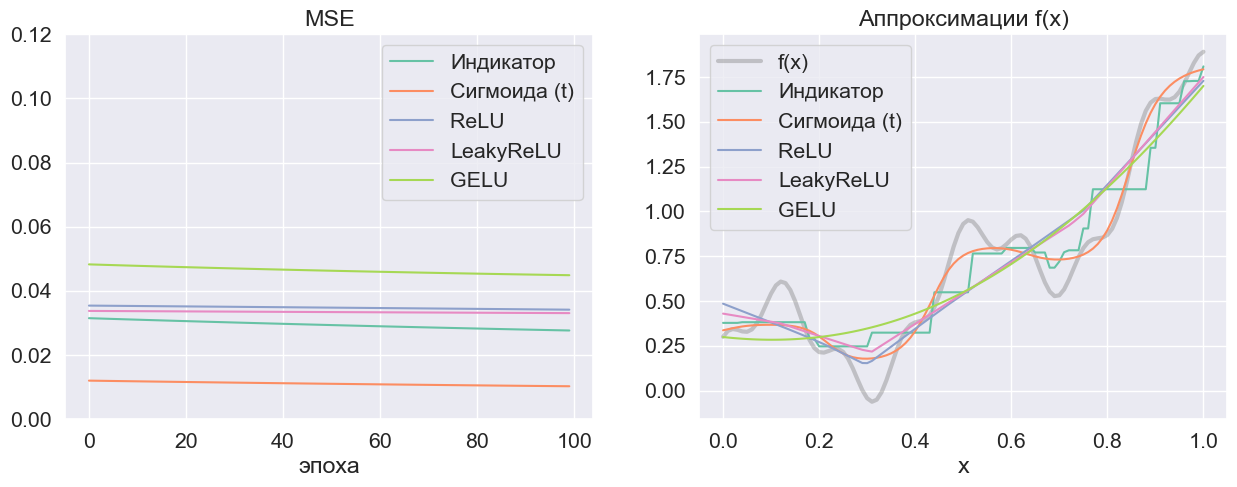

In [222]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='grey', lw=3, alpha=.4)

for name, (func, lr) in activation_functions.items():
    MSEs, y_preds = [], []
    model = MyModel(n_hidden=100, activation=func)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(n_times):
        history = train(model, optimizer, mse, x, y_true, n_epochs=100)
        y_preds.append(eval(model, x))
        MSEs.append(history['loss'])
    MSEs = np.array(MSEs)
    best = np.nanargmin(MSEs[:, -1])
    print(name, '\t', np.round(MSEs[best][-1], 4))
    axs[0].plot(MSEs[best], label=name)
    axs[1].plot(x.ravel(), y_preds[best].ravel(), label=name)

axs[0].legend()
axs[1].legend()
axs[0].set_title('MSE')
axs[1].set_title('Аппроксимации f(x)')
axs[0].set_xlabel('эпоха')
axs[1].set_xlabel('x')
axs[0].set_ylim(0, 0.12)  # с 1.2 было не видно - предположу, что опечатка
plt.show()

***Ответ:** судя по левому графику, наибольшая MSE получилась у GELU, а наименьшая - у сигмоиды с температурой (индикатор, к слову, на втором месте, уступив лишь сигмоиде). Судя по правому графику, модель где функция активации - сигмоида, смогла приблизить искомую функцию точнее всего. Модель с индикаторной функцией активации, в целом, неплохо справилась, но уступила сигмоиде и создала ступенчатый график, что может иметь сниженную практическую пользу.*

Вернемся к индикаторной функции активации. Исследуйте то, как обучается модель в зависимости от ширины первого слоя (ширина = кол-во нейронов). Рассмотрим значения 5, 10, 20, 50, 100.  Теперь будем запускать инициализацию по 100 раз. Не беспокойтесь, считается довольно шустро. Для каждой ширины слоя, построим графики зависимости функции ошибки от эпохи обучения. Также построим график среднего предсказания с доверительным интервалом ширины $2\sigma$ (здесь корень из дисперсии), сравните его с $f(x)$. Сделайте выводы.

In [223]:
n_times = 100

In [224]:
def test_different_hidden_sizes(activation_function, lr=0.01):
    sns.set_style("whitegrid")
    for n_hidden in (5, 10, 20, 50, 100):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        y_preds, MSEs = [], []

        for i in range(n_times):
            model = MyModel(n_hidden=n_hidden, activation=activation_function)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            loss_history = train(model, optimizer, mse, x, y_true, n_epochs=200)['loss']
            y_pred = eval(model, x)
            MSEs.append(mse(y_pred, y_true))
            y_preds.append(y_pred.ravel().detach())
            axs[0].plot(loss_history, color='blue', alpha=0.1)

        y_preds = torch.stack(y_preds)  # предсказания, их средние и стандартное отклонение
        y_pred_mean, y_pred_std = y_preds.mean(dim=0), y_preds.std(dim=0)

        axs[1].plot(x, y_pred_mean, color='blue', label='среднее предсказ.')
        axs[1].fill_between(
            x.ravel(), y_pred_mean - y_pred_std * 2, y_pred_mean + y_pred_std * 2,
            alpha=0.1, color='blue', label='дов. интервал')
        axs[1].plot(x.ravel(), y_true.ravel(), label='f(x)', color='#00BB99', lw=3)

        mse_mean = torch.mean(torch.tensor(MSEs))

        axs[1].legend()
        axs[0].set_title(f'MSE ~ {mse_mean:.2f}')
        axs[1].set_title('Аппроксимации f(x)')
        axs[0].set_xlabel('эпоха')
        axs[1].set_xlabel('x')
        axs[0].set_ylim(0, 1.2)

        fig.suptitle(f'{n_hidden} нейронов в 1-м слое')
        plt.show()

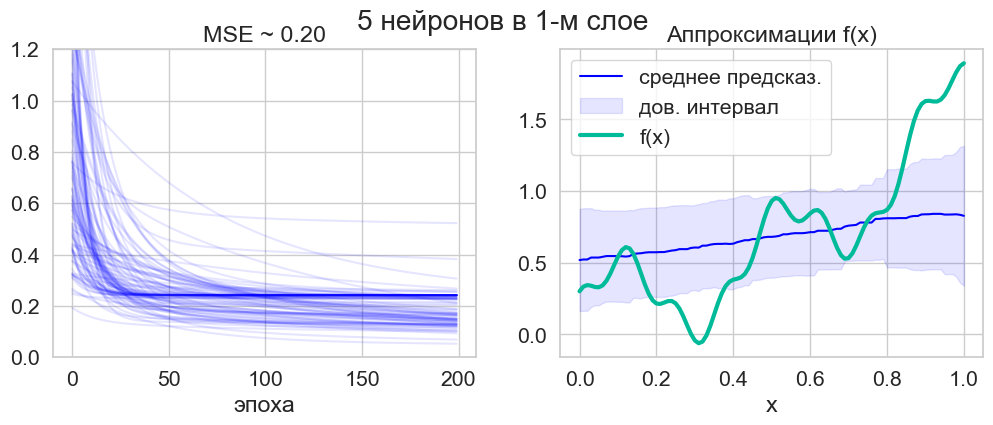

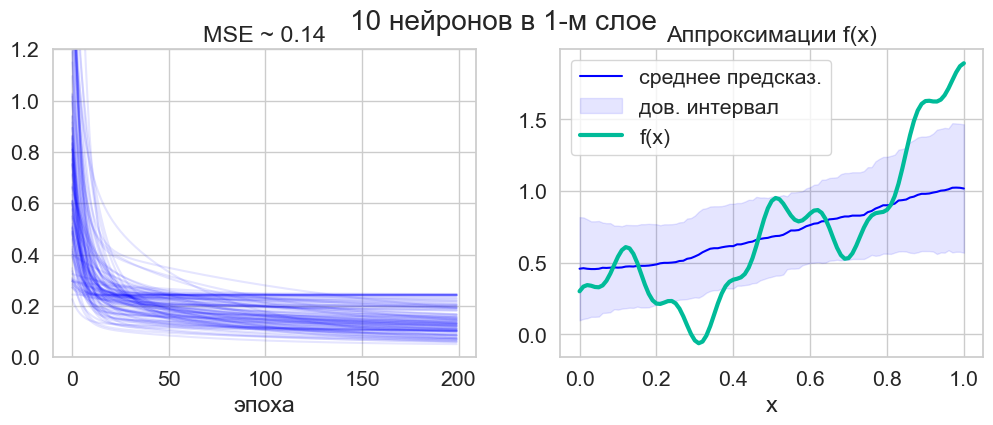

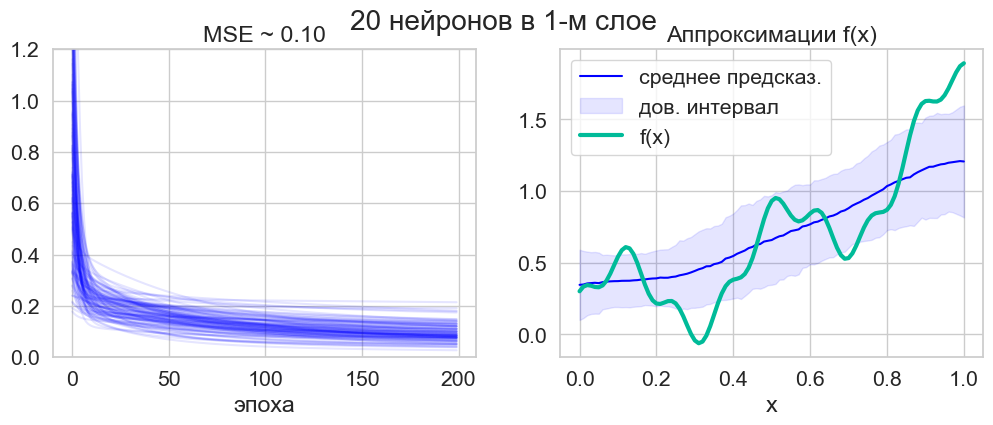

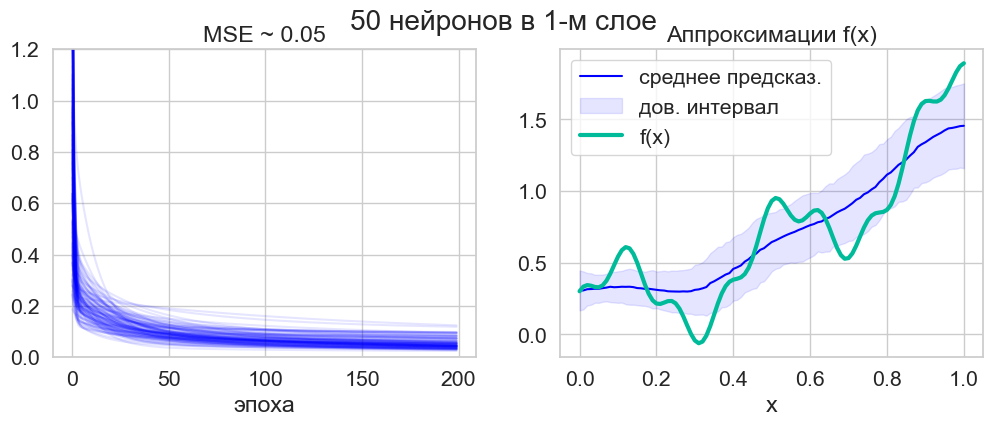

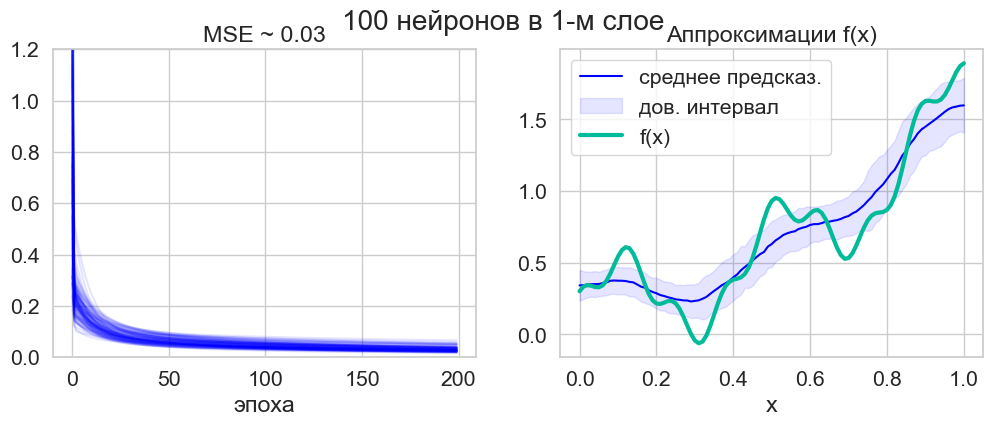

In [225]:
test_different_hidden_sizes(indicator, lr=0.01)  #lr как в словаре activation_functions выше

Повторите то же самое для функции активации ReLU. Сделайте выводы.

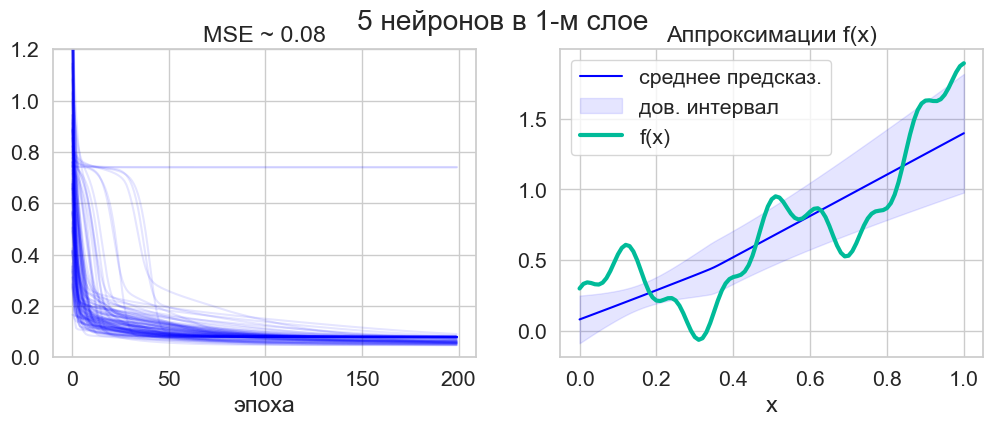

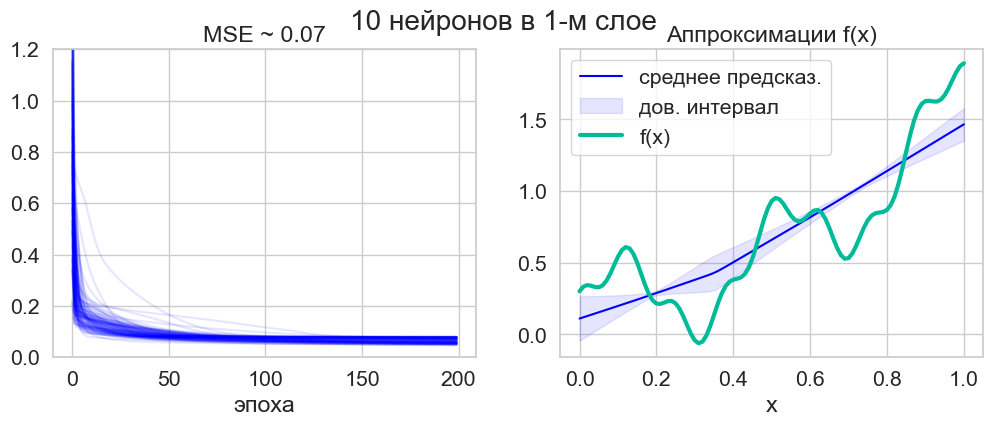

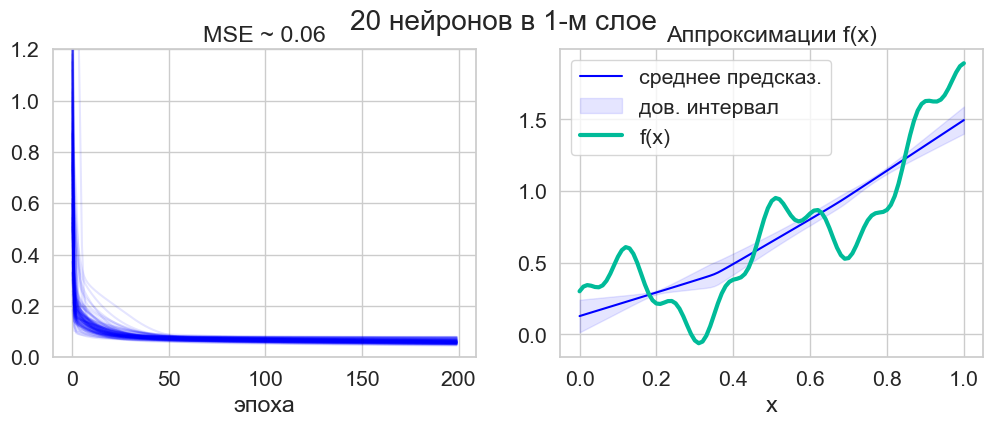

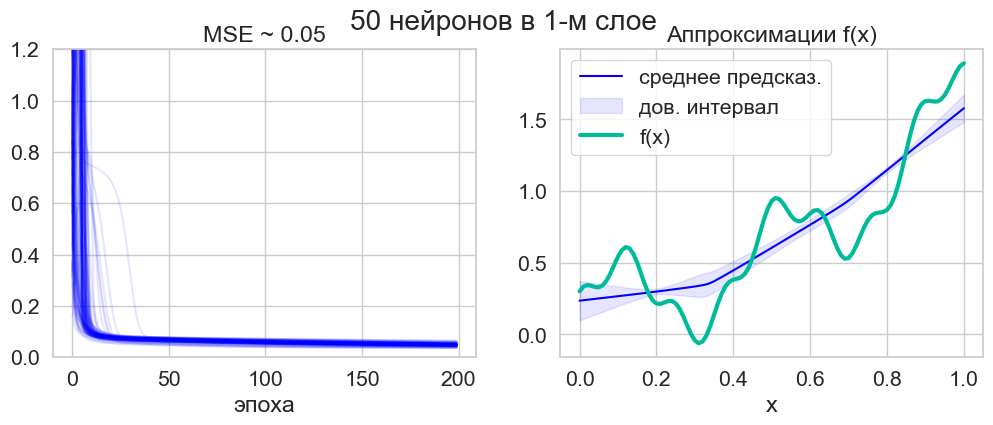

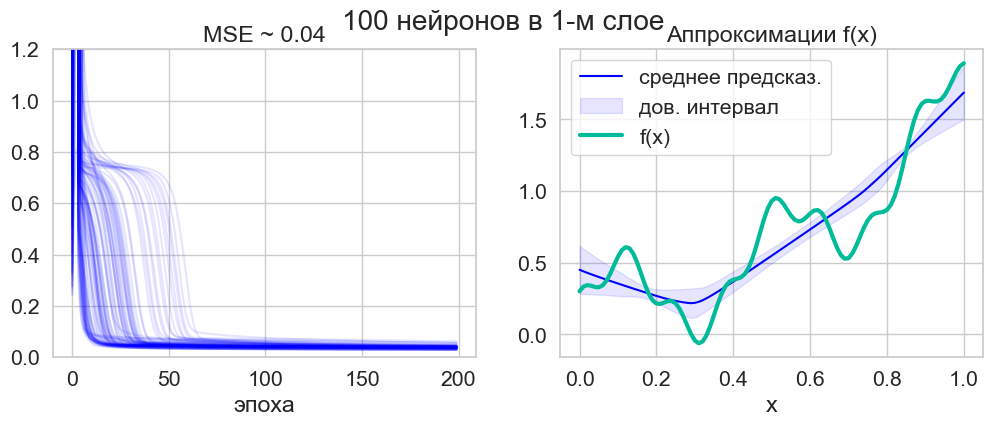

In [226]:
test_different_hidden_sizes(nn.ReLU(), lr=0.1)  #lr как в словаре activation_functions выше

***Ответ:***  
*1) чем шире слой, тем точнее подгоняется предсказание к реальной функции. Можно обобщить: чем больше у слоя параметров, тем выше variance. В том числе, выше и риск переобучиться, но в рамках этой задачи мы явно недообучаемся, так что пока что эта опасность себя не проявила*  
*2) сравнить две функции активации сложно, потому что в обоих случаях модель явно недообучается и примерно одинаково плохо аппроксимирует истинную функцию. По-моему, ReLU использоать все же лучше, т.к. ее градиент в положительной части не зануляется, что позволит сохранить его на всей глубине нейросети (а следующий логичный шаг - это увеличить число слоев)*  

---
***Вывод:** в рамках задачи удалось ближе познакомиться с простыми нейросетями и понять влияние различных параметров (таких как вид ф-ции активации и ширина слоя)*